<a href="https://colab.research.google.com/github/wujj0326/COVID_Risk_Competition/blob/master/COVID_Risk_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

In [389]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from datetime import datetime
from keras.models import load_model
import random

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
tf.compat.v1.set_random_seed(RANDOM_SEED)

Reference: https://medium.com/datadriveninvestor/covid19-time-series-forecasting-using-lstm-rnn-753a04944483

## Data Preparation

In [390]:
global_case = pd.read_csv('https://data.ca.gov/dataset/590188d5-8545-4c93-a9a0-e230f0db7290/resource/926fd08f-cc91-4828-af38-bd45de97f8c3/download/statewide_cases.csv')

In [391]:
global_case.head()

,county,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,date
0,Santa Clara,151.0,6.0,151,6,2020-03-18
1,Santa Clara,183.0,8.0,32,2,2020-03-19
2,Santa Clara,246.0,8.0,63,0,2020-03-20
3,Santa Clara,269.0,10.0,23,2,2020-03-21
4,Santa Clara,284.0,13.0,15,3,2020-03-22


In [392]:
la_cases = global_case[global_case['county']=='Los Angeles'].reset_index(drop=True)

In [393]:
la_cases['new_date'] = pd.to_datetime(la_cases['date'])

In [394]:
la_trunc = la_cases.loc[la_cases['date']>'2020-03-24',['totalcountconfirmed','totalcountdeaths','newcountconfirmed','newcountdeaths','new_date']]

In [395]:
la_trunc.head()

,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,new_date
7,725.0,10.0,92,-1,2020-03-25
8,1075.0,18.0,350,8,2020-03-26
9,1474.0,26.0,399,8,2020-03-27
10,1800.0,32.0,326,6,2020-03-28
11,2119.0,37.0,319,5,2020-03-29


In [396]:
la_daily = la_trunc.set_index('new_date')

In [397]:
la_daily.shape

(145, 4)

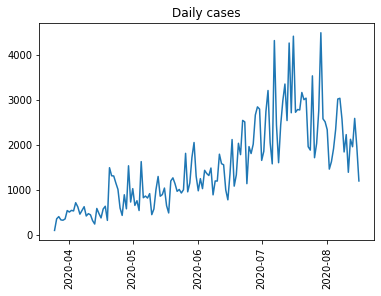

In [398]:
plt.plot(la_daily['newcountconfirmed'])
plt.title("Daily cases")
plt.xticks(rotation = 90)
plt.show()

In [399]:
la_ts_confirmed = la_daily.iloc[:,[0]]
la_ts_death = la_daily.iloc[:,[1]]

## Confirmed Model

### Preprocessing

In [400]:
len(la_ts_confirmed)

145

In [401]:
# predict 5 days afterwards
x = len(la_ts_confirmed)-5
x

140

In [402]:
train = la_ts_confirmed.iloc[:x]
test = la_ts_confirmed.iloc[x:]
train

,totalcountconfirmed
new_date,
2020-03-25,725.0
2020-03-26,1075.0
2020-03-27,1474.0
2020-03-28,1800.0
2020-03-29,2119.0
...,...
2020-08-07,204406.0
2020-08-08,206971.0
2020-08-09,208810.0


In [403]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
print(scaled_train[-5:])

[[0.96213911]
 [0.97425554]
 [0.98294252]
 [0.99345288]
 [1.        ]]


In [404]:
print(scaled_test)

[[1.01001908]
 [1.01925402]
 [1.03146965]
 [1.04072821]
 [1.04636365]]


In [405]:
# ?TimeseriesGenerator

# This class takes in a sequence of data-points gathered at
# equal intervals, along with time series parameters such as
# stride, length of history, etc., to produce batches for
# training/validation.

In [406]:
## how to decide num of inputs , 
n_input = 5  ## number of steps
n_features = 1 ## number of features you want to predict (for univariate time series n_features=1)
generator = TimeseriesGenerator(data = scaled_train, targets = scaled_train, length = n_input, batch_size=1)

In [407]:
len(generator)

135

we are taking 5 steps i.e taking 5 data points in account to predict 6th data point. So, The batches would be [feed=[t1,t2,t3,t4,t5],predict=t6].

Therefore, the [-6] data point would be the last one which contains all true data.

In [408]:
generator[-6]

(array([[[0.94780723],
         [0.96213911],
         [0.97425554],
         [0.98294252],
         [0.99345288]]]), array([[1.]]))

### Model Building

In [409]:
model = Sequential()
model.add(LSTM(150,activation="relu",input_shape=(n_input,n_features)))
model.add(Dropout(0.2))
model.add(Dense(75, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer="adam",loss="mse")

In [410]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 150)               91200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 75)                11325     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 76        
Total params: 102,601
Trainable params: 102,601
Non-trainable params: 0
_________________________________________________________________


In [411]:
validation_set = np.append(scaled_train[-1],scaled_test)
validation_set=validation_set.reshape(6,1)
validation_set

array([[1.        ],
       [1.01001908],
       [1.01925402],
       [1.03146965],
       [1.04072821],
       [1.04636365]])

In [412]:
validation_gen = TimeseriesGenerator(validation_set, validation_set, length=n_input, batch_size=1)

In [413]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)

In [414]:
model.fit_generator(generator, validation_data=validation_gen, epochs=100, callbacks=[early_stop], steps_per_epoch=10)

Epoch 1/100
10/10 [==============================] - 0s 25ms/step - loss: 0.2185 - val_loss: 0.6696
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0226 - val_loss: 0.3850
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0344 - val_loss: 0.1804
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0125 - val_loss: 0.0563
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0178 - val_loss: 0.0058
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0049
Epoch 8/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0050
Epoch 9/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0042
Epoch 10/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 4.5553e-06
Epoc

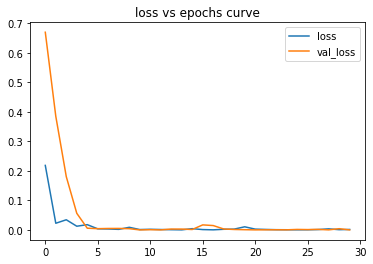

In [415]:
pd.DataFrame(model.history.history).plot(title="loss vs epochs curve")

### Forecasting

In [416]:
## holding predictions
test_prediction = []

##last n points from training set
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

In [417]:
## how far in future we can predict
for i in range(len(test)+7):
    current_pred = model.predict(current_batch)[0]
    test_prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [418]:
### inverse scaled data
true_prediction = scaler.inverse_transform(test_prediction)
true_prediction[:,0]

array([214664.74429703, 216701.32520485, 218657.75616455, 220636.82393265,
       222577.17947769, 224622.97157288, 226636.28476906, 228647.7809639 ,
       230672.34947395, 232712.00918961, 234772.94296265, 236840.71572685])

In [419]:
time_series_array = test.index
for k in range(0,7):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))
time_series_array

DatetimeIndex(['2020-08-12', '2020-08-13', '2020-08-14', '2020-08-15',
               '2020-08-16', '2020-08-17', '2020-08-18', '2020-08-19',
               '2020-08-20', '2020-08-21', '2020-08-22', '2020-08-23'],
              dtype='datetime64[ns]', name='new_date', freq=None)

In [420]:
df_forecast = pd.DataFrame(columns=["confirmed","confirmed_predicted"],index=time_series_array)
df_forecast.loc[:,"confirmed_predicted"] = true_prediction[:,0]
df_forecast.loc[:,"confirmed"] = test['totalcountconfirmed']

In [421]:
df_forecast

,confirmed,confirmed_predicted
new_date,,
2020-08-12,214542.0,214664.744297
2020-08-13,216497.0,216701.325205
2020-08-14,219083.0,218657.756165
2020-08-15,221043.0,220636.823933
2020-08-16,222236.0,222577.179478
2020-08-17,NaN,224622.971573
2020-08-18,NaN,226636.284769
2020-08-19,NaN,228647.780964
2020-08-20,NaN,230672.349474


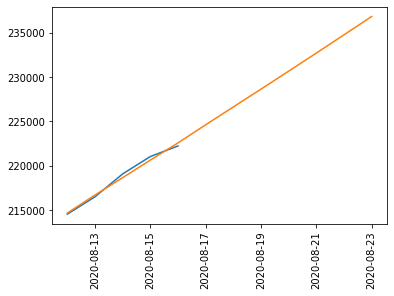

In [422]:
plt.plot(df_forecast)
plt.xticks(rotation = 90)
plt.show()

### Generate Predicted Confirmed Data

In [423]:
df_forecast['confirmed_predicted'] = round(df_forecast['confirmed_predicted'],0)

In [424]:
stdev = np.std(df_forecast['confirmed_predicted'])
interval = stdev*1.96

In [425]:
df_forecast['confirmed_high'] = round(df_forecast['confirmed_predicted']+interval,0)
df_forecast['confirmed_low'] = round(df_forecast['confirmed_predicted']-interval,0)
df_forecast

,confirmed,confirmed_predicted,confirmed_high,confirmed_low
new_date,,,,
2020-08-12,214542.0,214665.0,228277.0,201053.0
2020-08-13,216497.0,216701.0,230313.0,203089.0
2020-08-14,219083.0,218658.0,232270.0,205046.0
2020-08-15,221043.0,220637.0,234249.0,207025.0
2020-08-16,222236.0,222577.0,236189.0,208965.0
2020-08-17,NaN,224623.0,238235.0,211011.0
2020-08-18,NaN,226636.0,240248.0,213024.0
2020-08-19,NaN,228648.0,242260.0,215036.0
2020-08-20,NaN,230672.0,244284.0,217060.0


In [426]:
# cases_prediction = df_forecast.iloc[-7:,1:]

## Death Model

### Preprocessing

In [427]:
# The length of train size
x

140

In [428]:
train_d = la_ts_death.iloc[:x]
test_d = la_ts_death.iloc[x:]
train_d

,totalcountdeaths
new_date,
2020-03-25,10.0
2020-03-26,18.0
2020-03-27,26.0
2020-03-28,32.0
2020-03-29,37.0
...,...
2020-08-07,4918.0
2020-08-08,4967.0
2020-08-09,4977.0


In [429]:
scaler_d = MinMaxScaler()
scaler_d.fit(train_d)
scaled_train = scaler_d.transform(train_d)
scaled_test = scaler_d.transform(test_d)
print(scaled_train[-5:])

[[0.97245889]
 [0.98216762]
 [0.984149  ]
 [0.98791361]
 [1.        ]]


In [430]:
scaled_test

array([[1.01030315],
       [1.02258768],
       [1.03110759],
       [1.03724985],
       [1.03903309]])

In [431]:
## how to decide num of inputs , 
n_input = 5  ## number of steps
n_features = 1 ## number of features you want to predict (for univariate time series n_features=1)
generator = TimeseriesGenerator(data = scaled_train, targets = scaled_train, length = n_input, batch_size=1)

In [432]:
generator[-6]

(array([[[0.96275015],
         [0.97245889],
         [0.98216762],
         [0.984149  ],
         [0.98791361]]]), array([[1.]]))

### Model Building

In [433]:
model_t = Sequential()
model_t.add(LSTM(180,activation="relu",input_shape=(n_input,n_features)))
model_t.add(Dropout(0.3))
model_t.add(Dense(60, activation='relu'))
model_t.add(Dense(units=1))
model_t.compile(optimizer="adam",loss="mse")

In [434]:
validation_set = np.append(scaled_train[-1],scaled_test)
validation_set=validation_set.reshape(6,1)
validation_set

array([[1.        ],
       [1.01030315],
       [1.02258768],
       [1.03110759],
       [1.03724985],
       [1.03903309]])

In [435]:
validation_gen = TimeseriesGenerator(validation_set, validation_set, length=n_input, batch_size=1)

In [436]:
model_t.fit_generator(generator, validation_data=validation_gen, epochs=100, callbacks=[early_stop], steps_per_epoch=10)

Epoch 1/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1532 - val_loss: 0.5394
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 0.1053 - val_loss: 0.1447
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0146 - val_loss: 0.0054
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0132 - val_loss: 0.0092
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0176 - val_loss: 3.9633e-06
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0014
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0034 - val_loss: 0.0051
Epoch 8/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0028 - val_loss: 0.0119
Epoch 9/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 10/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 0.0084
Epoc

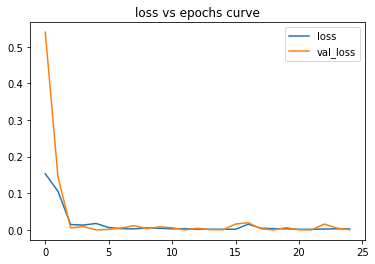

In [437]:
pd.DataFrame(model_t.history.history).plot(title="loss vs epochs curve")

### Forecasting

In [438]:
## holding predictions
test_pred_death = []

##last n points from training set
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

In [439]:
## how far in future we can predict
for i in range(len(test_d)+7):
    current_pred = model_t.predict(current_batch)[0]
    test_pred_death.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [440]:
### inverse scaled data
true_pred_death = scaler_d.inverse_transform(test_pred_death)
true_pred_death[:,0]

array([5101.23686528, 5134.84619761, 5165.84858358, 5200.97467375,
       5239.05125201, 5272.82423294, 5304.73932087, 5336.42698538,
       5368.29935622, 5399.58632231, 5429.63509417, 5459.03769469])

In [441]:
test_d['totalcountdeaths'].values

array([5109., 5171., 5214., 5245., 5254.])

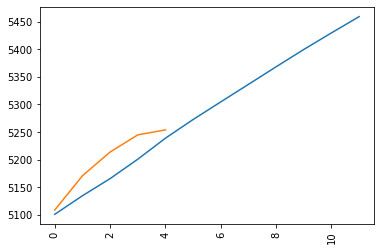

In [442]:
plt.plot(true_pred_death[:,0])
plt.plot(test_d['totalcountdeaths'].values)
plt.xticks(rotation = 90)
plt.show()

## Generate Predicted Data

In [443]:
df_forecast.loc[:,"death_predicted"] = true_pred_death[:,0]
df_forecast.loc[:,"death"] = test_d['totalcountdeaths']

In [444]:
df_forecast

,confirmed,confirmed_predicted,confirmed_high,confirmed_low,death_predicted,death
new_date,,,,,,
2020-08-12,214542.0,214665.0,228277.0,201053.0,5101.236865,5109.0
2020-08-13,216497.0,216701.0,230313.0,203089.0,5134.846198,5171.0
2020-08-14,219083.0,218658.0,232270.0,205046.0,5165.848584,5214.0
2020-08-15,221043.0,220637.0,234249.0,207025.0,5200.974674,5245.0
2020-08-16,222236.0,222577.0,236189.0,208965.0,5239.051252,5254.0
2020-08-17,NaN,224623.0,238235.0,211011.0,5272.824233,NaN
2020-08-18,NaN,226636.0,240248.0,213024.0,5304.739321,NaN
2020-08-19,NaN,228648.0,242260.0,215036.0,5336.426985,NaN
2020-08-20,NaN,230672.0,244284.0,217060.0,5368.299356,NaN


In [445]:
df_forecast['confirmed_predicted'] = round(df_forecast['confirmed_predicted'],0)
df_forecast['death_predicted'] = round(df_forecast['death_predicted'],0)

In [446]:
stdev_c = np.std(df_forecast['confirmed_predicted'])
interval_c = stdev*1.96

In [447]:
stdev_d = np.std(df_forecast['death_predicted'])
interval_d = stdev_d*1.96

In [448]:
df_forecast['confirmed_high'] = round(df_forecast['confirmed_predicted'] + interval_c,0)
df_forecast['confirmed_low'] = round(df_forecast['confirmed_predicted'] - interval_c,0)
df_forecast['death_high'] = round(df_forecast['death_predicted'] + interval_d,0)
df_forecast['death_low'] = round(df_forecast['death_predicted'] - interval_d,0)
df_forecast

,confirmed,confirmed_predicted,confirmed_high,confirmed_low,death_predicted,death,death_high,death_low
new_date,,,,,,,,
2020-08-12,214542.0,214665.0,228277.0,201053.0,5101.0,5109.0,5323.0,4879.0
2020-08-13,216497.0,216701.0,230313.0,203089.0,5135.0,5171.0,5357.0,4913.0
2020-08-14,219083.0,218658.0,232270.0,205046.0,5166.0,5214.0,5388.0,4944.0
2020-08-15,221043.0,220637.0,234249.0,207025.0,5201.0,5245.0,5423.0,4979.0
2020-08-16,222236.0,222577.0,236189.0,208965.0,5239.0,5254.0,5461.0,5017.0
2020-08-17,NaN,224623.0,238235.0,211011.0,5273.0,NaN,5495.0,5051.0
2020-08-18,NaN,226636.0,240248.0,213024.0,5305.0,NaN,5527.0,5083.0
2020-08-19,NaN,228648.0,242260.0,215036.0,5336.0,NaN,5558.0,5114.0
2020-08-20,NaN,230672.0,244284.0,217060.0,5368.0,NaN,5590.0,5146.0


In [449]:
# extract the last 8 row because we would calculte the difference between the day and its previous day
# therefore, we would get the 7 days (one week) differences 
predicted_data = df_forecast.iloc[-8:,[1,2,3,4,6,7]]

In [450]:
predicted_data

,confirmed_predicted,confirmed_high,confirmed_low,death_predicted,death_high,death_low
new_date,,,,,,
2020-08-16,222577.0,236189.0,208965.0,5239.0,5461.0,5017.0
2020-08-17,224623.0,238235.0,211011.0,5273.0,5495.0,5051.0
2020-08-18,226636.0,240248.0,213024.0,5305.0,5527.0,5083.0
2020-08-19,228648.0,242260.0,215036.0,5336.0,5558.0,5114.0
2020-08-20,230672.0,244284.0,217060.0,5368.0,5590.0,5146.0
2020-08-21,232712.0,246324.0,219100.0,5400.0,5622.0,5178.0
2020-08-22,234773.0,248385.0,221161.0,5430.0,5652.0,5208.0
2020-08-23,236841.0,250453.0,223229.0,5459.0,5681.0,5237.0


In [451]:
# predicted_data.to_csv('predicted_data.csv')

## Get Risk Score

### import risk data

In [452]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [453]:
risk = pd.read_csv('https://raw.githubusercontent.com/wujj0326/COVID_Risk_Competition/master/Data/risk_confirmed.csv')

In [454]:
risk.head()

,City,confirmed_cases,death_cases,pop2010,avg_traffic,avg_asthma,avg_cardiovascular,avg_poverty,avg_elderly,pop_dens
0,Acton,11,1,53654,1058.69,73.62,11.00,70.81,5.24,120974.0
1,Agoura Hills,35,1,60009,1023.45,77.60,10.95,72.49,5.45,177875.5
2,Alhambra,226,8,112060,1816.86,47.43,7.17,46.00,10.40,551582.0
3,Altadena,157,5,69531,1379.59,34.64,5.34,55.34,10.67,864902.9
4,Arcadia,104,7,70416,1305.56,49.61,6.12,73.43,8.78,755363.9


In [455]:
# normalize the scale by using minmaxscaler
scale_risk = MinMaxScaler(feature_range=(0, 1))
features = scale_risk.fit_transform(risk.iloc[:,3:-1])

#  vulnerable factors related to death cases

# •       elderly

# •       asthma

# •       cardiovascular

#  vulnearble factors related to infected cases

# •       poverty: the higher the value the poorer the area

# •       traffic

# •       population

confirm_feat = np.sum(features[:,np.r_[0,1,4]],axis=1)
death_feat = np.sum(features[:,np.r_[2,3,5]],axis=1)

In [456]:
# apply sigmoid function to confirm feature and death feature
sig_confirmed = 1/(1 + np.exp(confirm_feat)) 
sig_death = 1/(1 + np.exp(death_feat)) 

In [457]:
risk['confirmed_score'] = sig_confirmed
risk['death_score'] = sig_death

In [458]:
risk_score = risk.iloc[:,np.r_[0,-2,-1]]

### Get Hazard Score


In [459]:
prediction = predicted_data.loc[:, ['confirmed_predicted', 'death_predicted']]

In [460]:
prediction.loc[:,'positive_increase'] = prediction['confirmed_predicted'].diff()
prediction.loc[:,'dead_increase'] = prediction['death_predicted'].diff()

In [461]:
prediction = prediction.iloc[1:,[2,3]].reset_index()

In [462]:
# normalize the hazard value
def norm_hazard(alpha,data):
  alpha = alpha
  data['hazard'] = data['positive_increase']*alpha + data['dead_increase']*(1-alpha)
  return data

In [463]:
pred_haz = norm_hazard(0.012,prediction).loc[:,['new_date','hazard']]

In [464]:
pred_haz

,new_date,hazard
0,2020-08-17,58.144
1,2020-08-18,55.772
2,2020-08-19,54.772
3,2020-08-20,55.904
4,2020-08-21,56.096
5,2020-08-22,54.372
6,2020-08-23,53.468


In [465]:
pred_haz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   new_date  7 non-null      datetime64[ns]
 1   hazard    7 non-null      float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 240.0 bytes


In [466]:
pred_haz['new_date'] = pred_haz['new_date'].astype('str')

### Get Risk Score

In [ ]:
# To get the risk score for each date
risk_score['{}'.format(pred_haz['new_date'][0])] = risk_score['confirmed_score']*pred_haz['hazard'][0]
risk_score['{}'.format(pred_haz['new_date'][1])] = risk_score['confirmed_score']*pred_haz['hazard'][1]
risk_score['{}'.format(pred_haz['new_date'][2])] = risk_score['confirmed_score']*pred_haz['hazard'][2]
risk_score['{}'.format(pred_haz['new_date'][3])] = risk_score['confirmed_score']*pred_haz['hazard'][3]
risk_score['{}'.format(pred_haz['new_date'][4])] = risk_score['confirmed_score']*pred_haz['hazard'][4]
risk_score['{}'.format(pred_haz['new_date'][5])] = risk_score['confirmed_score']*pred_haz['hazard'][5]

In [468]:
risk_score

,City,confirmed_score,death_score,2020-08-17,2020-08-18,2020-08-19,2020-08-20,2020-08-21,2020-08-22
0,Acton,0.189272,0.220192,11.005058,10.556103,10.366831,10.581087,10.617428,10.291122
1,Agoura Hills,0.181774,0.213950,10.569079,10.137911,9.956137,10.161905,10.196806,9.883427
2,Alhambra,0.144250,0.270825,8.387270,8.045109,7.900859,8.064150,8.091846,7.843159
3,Altadena,0.187301,0.329177,10.890402,10.446125,10.258824,10.470848,10.506810,10.183904
4,Arcadia,0.155135,0.314134,9.020141,8.652162,8.497028,8.672640,8.702426,8.434974
...,...,...,...,...,...,...,...,...,...
85,Venice,0.341497,0.290481,19.856010,19.045979,18.704482,19.091057,19.156624,18.567883
86,West Hills,0.418424,0.205003,24.328820,23.336319,22.917895,23.391551,23.471888,22.750526
87,Wilmington,0.234219,0.206903,13.618446,13.062878,12.828658,13.093795,13.138765,12.734971
88,Winnetka,0.254805,0.189505,14.815370,14.210973,13.956168,14.244607,14.293529,13.854246


#### Weekly Risk Score and Level

In [ ]:
# To get the weekly score for each city and store it to a DF
risk_score['weekly_score'] = risk_score.iloc[:,3:].mean(axis=1)
weekly_risk = risk_score.loc[:,['City','weekly_score']]

In [470]:
weekly_risk

,City,weekly_score
0,Acton,10.569605
1,Agoura Hills,10.150877
2,Alhambra,8.055399
3,Altadena,10.459486
4,Arcadia,8.663229
...,...,...
85,Venice,19.070339
86,West Hills,23.366166
87,Wilmington,13.079585
88,Winnetka,14.229149


In [471]:
# Get the weekly level
weekly_level = []
for risk in weekly_risk['weekly_score']:
  if risk <= weekly_risk['weekly_score'].quantile(0.25):
    b = 1
  elif risk <= weekly_risk['weekly_score'].quantile(0.50) and risk >weekly_risk['weekly_score'].quantile(0.25):
    b = 2 
  elif risk <= weekly_risk['weekly_score'].quantile(0.75) and risk > weekly_risk['weekly_score'].quantile(0.50):
    b = 3
  else: b =4
  weekly_level.append(b)

In [472]:
weekly_risk['level'] = weekly_level

In [473]:
weekly_risk

,City,weekly_score,level
0,Acton,10.569605,2
1,Agoura Hills,10.150877,1
2,Alhambra,8.055399,1
3,Altadena,10.459486,2
4,Arcadia,8.663229,1
...,...,...,...
85,Venice,19.070339,4
86,West Hills,23.366166,4
87,Wilmington,13.079585,2
88,Winnetka,14.229149,3


In [474]:
# weekly_risk.to_csv('weekly_risk_score.csv', index=False)

#### Time Series Risk Score

In [475]:
risk_trunc = risk_score.iloc[:,[0,3,4,5,6,7,8]]

In [476]:
risk_trunc

,City,2020-08-17,2020-08-18,2020-08-19,2020-08-20,2020-08-21,2020-08-22
0,Acton,11.005058,10.556103,10.366831,10.581087,10.617428,10.291122
1,Agoura Hills,10.569079,10.137911,9.956137,10.161905,10.196806,9.883427
2,Alhambra,8.387270,8.045109,7.900859,8.064150,8.091846,7.843159
3,Altadena,10.890402,10.446125,10.258824,10.470848,10.506810,10.183904
4,Arcadia,9.020141,8.652162,8.497028,8.672640,8.702426,8.434974
...,...,...,...,...,...,...,...
85,Venice,19.856010,19.045979,18.704482,19.091057,19.156624,18.567883
86,West Hills,24.328820,23.336319,22.917895,23.391551,23.471888,22.750526
87,Wilmington,13.618446,13.062878,12.828658,13.093795,13.138765,12.734971
88,Winnetka,14.815370,14.210973,13.956168,14.244607,14.293529,13.854246


In [477]:
# transpose the data to time series
trans = risk_trunc.set_index('City').transpose()

In [478]:
trans

City,Acton,Agoura Hills,Alhambra,Altadena,Arcadia,Artesia,Avalon,Baldwin Park,Bell,Bell Gardens,Bellflower,Beverly Hills,Burbank,Calabasas,Canoga Park,Chatsworth,Claremont,Commerce,Compton,Covina,Cudahy,Culver City,Downey,Duarte,El Monte,El Segundo,Encino,Gardena,Glendale,Glendora,Granada Hills,Harbor City,Hawthorne,Hermosa Beach,Hidden Hills,Huntington Park,Industry,Inglewood,Irwindale,La Canada Flintridge,...,Newhall,North Hills,North Hollywood,Northridge,Pacific Palisades,Pacoima,Palmdale,Panorama City,Paramount,Pico Rivera,Playa Del Rey,Playa Vista,Pomona,Porter Ranch,Rancho Palos Verdes,Redondo Beach,Reseda,Rolling Hills,Rolling Hills Estates,San Dimas,San Fernando,San Pedro,Sherman Oaks,South El Monte,South Gate,South Pasadena,Studio City,Sun Valley,Sunland,Sylmar,Tarzana,Torrance,Tujunga,Valley Village,Van Nuys,Venice,West Hills,Wilmington,Winnetka,Woodland Hills
2020-08-17,11.005058,10.569079,8.387270,10.890402,9.020141,5.837272,14.801925,8.473897,10.378497,11.566486,9.156622,25.127216,17.611330,16.336579,11.961428,18.303536,8.812353,11.063499,10.610320,16.048776,13.639991,15.964627,6.678915,13.340098,13.180721,16.880583,11.896608,8.966075,11.466675,10.992122,16.570103,16.296023,9.112158,13.376997,9.484923,10.004291,17.167478,13.340417,7.495122,14.676995,...,14.541396,9.142931,8.750603,11.554275,24.836884,6.767716,13.290716,10.644833,6.853273,8.594825,26.634974,23.356013,15.693687,19.315037,14.491794,14.678206,16.379062,15.325905,13.901939,15.147827,15.195886,16.218927,10.719445,25.077209,13.336192,24.837466,20.822027,13.105133,17.611199,13.749292,12.444008,16.878576,20.334443,20.291416,6.736196,19.856010,24.328820,13.618446,14.815370,18.867654
2020-08-18,10.556103,10.137911,8.045109,10.446125,8.652162,5.599139,14.198076,8.128203,9.955103,11.094628,8.783075,24.102144,16.892871,15.670124,11.473458,17.556839,8.452851,10.612161,10.177469,15.394062,13.083544,15.313346,6.406447,12.795886,12.643010,16.191935,11.411283,8.600302,10.998889,10.543696,15.894121,15.631222,8.740425,12.831279,9.097983,9.596163,16.467126,12.796191,7.189356,14.078243,...,13.948176,8.769943,8.393620,11.082915,23.823657,6.491626,12.748517,10.210574,6.573692,8.244197,25.548393,22.403198,15.053459,18.527075,13.900597,14.079405,15.710874,14.700680,13.334806,14.529868,14.575966,15.557271,10.282142,24.054177,12.792138,23.824215,19.972587,12.570506,16.892745,13.188386,11.936351,16.190010,19.504894,19.463622,6.461391,19.045979,23.336319,13.062878,14.210973,18.097943
2020-08-19,10.366831,9.956137,7.900859,10.258824,8.497028,5.498745,13.943503,7.982463,9.776607,10.895700,8.625593,23.669989,16.589979,15.389156,11.267737,17.242042,8.301290,10.421883,9.994985,15.118044,12.848954,15.038775,6.291579,12.566453,12.416319,15.901611,11.206677,8.446097,10.801678,10.354646,15.609137,15.350952,8.583708,12.601212,8.934855,9.424103,16.171868,12.566754,7.060450,13.825818,...,13.698083,8.612696,8.243121,10.884197,23.396495,6.375230,12.519935,10.027497,6.455825,8.096377,25.090307,22.001506,14.783548,18.194882,13.651357,13.826959,15.429175,14.437095,13.095711,14.269345,14.314616,15.278327,10.097782,23.622882,12.562773,23.397043,19.614476,12.345115,16.589856,12.951916,11.722331,15.899720,19.155168,19.114637,6.345537,18.704482,22.917895,12.828658,13.956168,17.773444
2020-08-20,10.581087,10.161905,8.064150,10.470848,8.672640,5.612391,14.231680,8.147440,9.978665,11.120887,8.803863,24.159189,16.932853,15.707212,11.500613,17.598392,8.472857,10.637278,10.201557,15.430496,13.114510,15.349589,6.421610,12.826171,12.672933,16.230258,11.438291,8.620657,11.024921,10.568650,15.931739,15.668218,8.761112,12.861647,9.119516,9.618875,16.506100,12.826477,7.206372,14.111563,...,13.981188,8.790699,8.413486,11.109146,23.880042,6.506990,12.778690,10.234740,6.589251,8.263709,25.608861,22.456222,15.089087,18.570925,13.933497,14.112728,15.748058,14.735474,13.366367,14.564257,14.610464,15.594092,10.306478,24.111108,12.822414,23.880601,20.019858,12.600258,16.932727,13.219600,11.964602,16.228328,19.551057,19

In [479]:
trans_reindex = trans.reset_index()

In [480]:
# melt the city name to one column
melted = pd.melt(trans_reindex, id_vars='index', value_vars=trans_reindex.columns[1:])

In [481]:
sort_melt = melted.sort_values(by='index').reset_index(drop=True).rename(columns={'index':'Date','value':'Score'})

In [482]:
sort_melt

,Date,City,Score
0,2020-08-17,Acton,11.005058
1,2020-08-17,Harbor City,16.296023
2,2020-08-17,Hawthorne,9.112158
3,2020-08-17,Hermosa Beach,13.376997
4,2020-08-17,Van Nuys,6.736196
...,...,...,...
535,2020-08-22,Northridge,10.804709
536,2020-08-22,Pacific Palisades,23.225631
537,2020-08-22,Pacoima,6.328671
538,2020-08-22,Lynwood,14.098000


##### Generate the levels

In [483]:
# Calculate the quantile for each date
q1 = np.quantile(trans,0.25,axis=1).reshape(-1,1)
q2 = np.quantile(trans,0.5,axis=1).reshape(-1,1)
q3 = np.quantile(trans,0.75,axis=1).reshape(-1,1)
quantiles = np.concatenate([q1,q2,q3], axis = 1)
quant_df = pd.DataFrame(quantiles, columns=['q1','q2','q3'], index=trans.index)

In [484]:
merged_with_quantile = pd.merge(sort_melt, quant_df, left_on='Date', right_on=quant_df.index)

In [485]:
# assign the level labels
level = []
for score, q1, q2, q3 in zip(merged_with_quantile['Score'], merged_with_quantile['q1'], merged_with_quantile['q2'], merged_with_quantile['q3']):
  if score <= q1:
    lev = 1
  elif score <= q2 and score > q1:
    lev = 2
  elif score <= q3 and score > q2:
    lev = 3
  else : 
    lev = 4
  level.append(lev)

In [490]:
merged_with_quantile['Daily_Level'] = level

,Date,City,Score,q1,q2,q3,Daily_Level
0,2020-08-17,Acton,11.005058,10.663486,13.825615,16.450325,2
1,2020-08-17,Harbor City,16.296023,10.663486,13.825615,16.450325,3
2,2020-08-17,Hawthorne,9.112158,10.663486,13.825615,16.450325,1
3,2020-08-17,Hermosa Beach,13.376997,10.663486,13.825615,16.450325,2
4,2020-08-17,Van Nuys,6.736196,10.663486,13.825615,16.450325,1
...,...,...,...,...,...,...,...
535,2020-08-22,Northridge,10.804709,9.971709,12.928701,15.383136,2
536,2020-08-22,Pacific Palisades,23.225631,9.971709,12.928701,15.383136,4
537,2020-08-22,Pacoima,6.328671,9.971709,12.928701,15.383136,1
538,2020-08-22,Lynwood,14.098000,9.971709,12.928701,15.383136,3


In [491]:
final_risk = merged_with_quantile.loc[:,['Date', 'City',	'Score', 'Daily_Level']]

In [492]:
final_risk

,Date,City,Score,Daily_Level
0,2020-08-17,Acton,11.005058,2
1,2020-08-17,Harbor City,16.296023,3
2,2020-08-17,Hawthorne,9.112158,1
3,2020-08-17,Hermosa Beach,13.376997,2
4,2020-08-17,Van Nuys,6.736196,1
...,...,...,...,...
535,2020-08-22,Northridge,10.804709,2
536,2020-08-22,Pacific Palisades,23.225631,4
537,2020-08-22,Pacoima,6.328671,1
538,2020-08-22,Lynwood,14.098000,3


In [489]:
# final_risk.to_csv('final_risk_score.csv',index=False)